## Setup

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch
import re
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Hubungkan ke Google Drive
drive.mount('/content/drive')

# Definisikan path utama proyek (sesuaikan jika nama folder Anda berbeda)
PROJECT_PATH = "/content/drive/MyDrive/CODE SKRIPSI"

print("Setup Selesai.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup Selesai.


## Fungsi

In [ ]:
def load_slang_dict(filepath):
    """Memuat kamus slang dari file CSV."""
    df_slang = pd.read_csv(filepath, header=None, names=['slang', 'formal'], encoding='latin-1')
    return pd.Series(df_slang.formal.values, index=df_slang.slang).to_dict()

def preprocess_text(text, slang_dictionary):
    """Membersihkan dan menormalisasi teks."""
    text = str(text).lower()
    words = text.split()
    normalized_words = [slang_dictionary.get(word, word) for word in words]
    text = " ".join(normalized_words)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_function(examples, tokenizer):
    """Menokenisasi teks."""
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def display_evaluation_visuals(y_true, y_pred, label_columns, dataset_name=""):
    """
    Menampilkan visualisasi Classification Report dan Confusion Matrix.
    """
    print("\n" + "="*50)
    print(f"Visualisasi Metrik Per Label (dari {dataset_name} Set)")
    print("="*50)

    report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=label_columns, zero_division=0, output_dict=True)).transpose()
    report_df_labels = report_df.drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'])

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    report_df_labels[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_title(f'Perbandingan Metrik per Label pada {dataset_name} Set', fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*50)
    print(f"Visualisasi Confusion Matrix Per Label (dari {dataset_name} Set)")
    print("="*50)

    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(4, 3, figsize=(15, 18))
    axes = axes.flatten()
    for i, (matrix, label) in enumerate(zip(mcm, label_columns)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=['Not', 'Is'], yticklabels=['Not', 'Is'])
        axes[i].set_title(f'CM untuk: {label}', fontsize=12)
    if len(label_columns) < len(axes):
        for j in range(len(label_columns), len(axes)): fig.delaxes(axes[j])
    plt.tight_layout(pad=3.0)
    plt.show()

print("Kumpulan Fungsi Pengujian Siap.")

Kumpulan Fungsi Pengujian Siap.


## Persiapan Dataset UJI

In [ ]:
YOUTUBE_DATA_PATH = os.path.join(PROJECT_PATH, 'data/DATA_UJI.csv')

print(f"Mempersiapkan dataset dari: {YOUTUBE_DATA_PATH}")

SLANG_DICT_PATH = os.path.join(PROJECT_PATH, 'data/new_kamusalay.csv')
slang_dict = load_slang_dict(SLANG_DICT_PATH)

# Memuat dataset uji
df_yt = pd.read_csv(YOUTUBE_DATA_PATH, encoding='latin-1')

text_column_yt = 'text' if 'text' in df_yt.columns else 'Tweet'
print(f"Jumlah baris sebelum dibersihkan: {len(df_yt)}")

df_yt.dropna(subset=[text_column_yt], inplace=True)

label_columns = ["HS", "HS_Individual", "HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "HS_Weak", "HS_Moderate", "HS_Strong"]
for col in label_columns:
    if col in df_yt.columns:
        df_yt[col] = df_yt[col].fillna(0)

print(f"Jumlah baris setelah dibersihkan: {len(df_yt)}")

print("Melakukan preprocessing pada kolom teks...")
df_yt['text_processed'] = df_yt[text_column_yt].apply(lambda x: preprocess_text(x, slang_dict))

# Membuat kolom 'labels' yang dibutuhkan Trainer
df_yt['labels'] = df_yt[label_columns].astype(np.float32).values.tolist()

df_for_dataset = df_yt[['text_processed', 'labels']].rename(columns={'text_processed': 'text'})

tokenizer_for_eval = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
youtube_dataset = Dataset.from_pandas(df_for_dataset)
youtube_dataset = youtube_dataset.map(lambda x: tokenize_function(x, tokenizer_for_eval), batched=True)

print(f"Dataset YouTube ({len(df_yt)} sampel) siap.")

Mempersiapkan dataset dari: /content/drive/MyDrive/CODE SKRIPSI/data/DATA_UJI.csv
Jumlah baris sebelum dibersihkan: 1100
Jumlah baris setelah dibersihkan: 1100
Melakukan preprocessing pada kolom teks...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

Dataset YouTube (1100 sampel) siap.


## Pengujian

Memuat model dari: /content/drive/MyDrive/CODE SKRIPSI/revisi/MODEL_FINAL_SIDANG_REVISI

Pengujian Final pada Dataset YouTube



Menerapkan threshold optimal per label...
--- Laporan Klasifikasi Final pada Dataset YouTube ---
               precision    recall  f1-score   support

           HS       0.84      0.81      0.83       394
HS_Individual       0.83      0.70      0.76       277
     HS_Group       0.74      0.68      0.70       120
  HS_Religion       0.85      0.61      0.71        18
      HS_Race       0.75      0.26      0.39        23
  HS_Physical       0.55      0.30      0.39        20
    HS_Gender       0.00      0.00      0.00         8
     HS_Other       0.85      0.73      0.79       365
      HS_Weak       0.79      0.67      0.72       260
  HS_Moderate       0.69      0.64      0.67       112
    HS_Strong       0.93      0.46      0.62        28

    micro avg       0.81      0.70      0.75      1625
    macro avg       0.71      0.53      0.60      1625
 weighted avg       0.81      0.70      0.75      1625
  samples avg       0.28      0.26      0.27      1625


Visualisasi Metrik

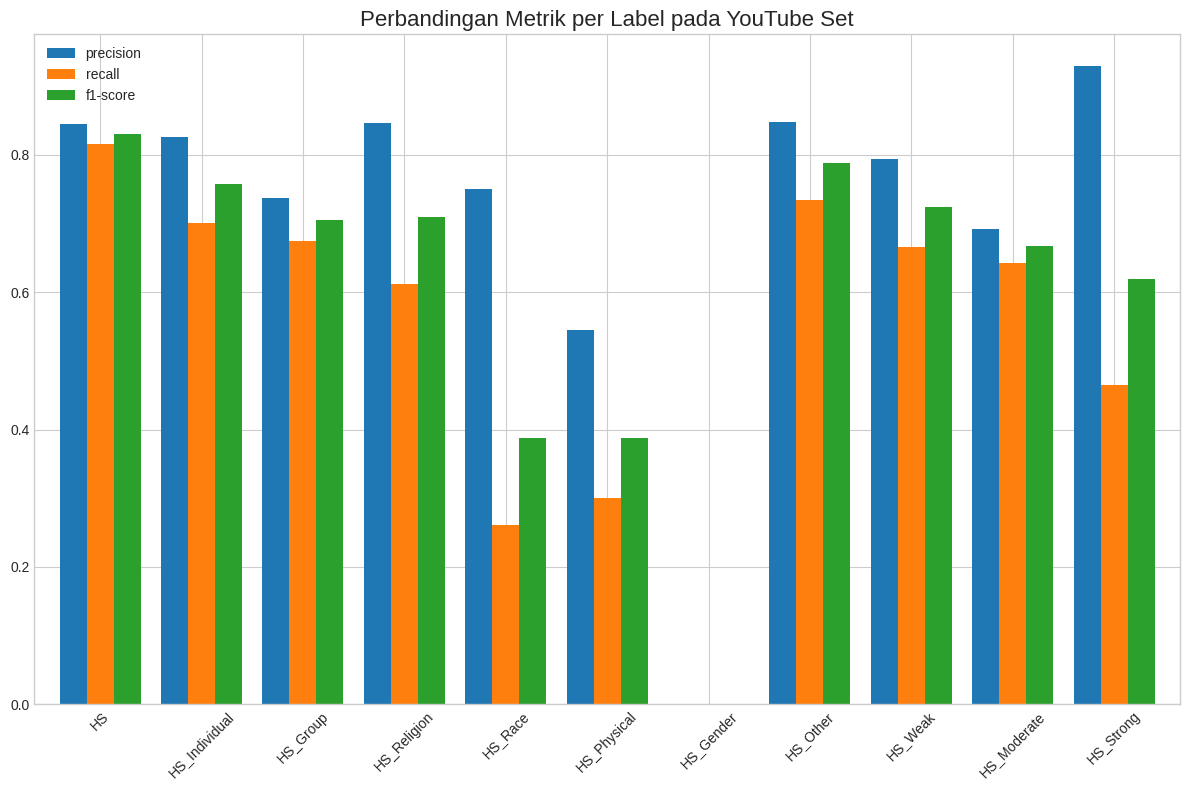


Visualisasi Confusion Matrix Per Label (dari YouTube Set)


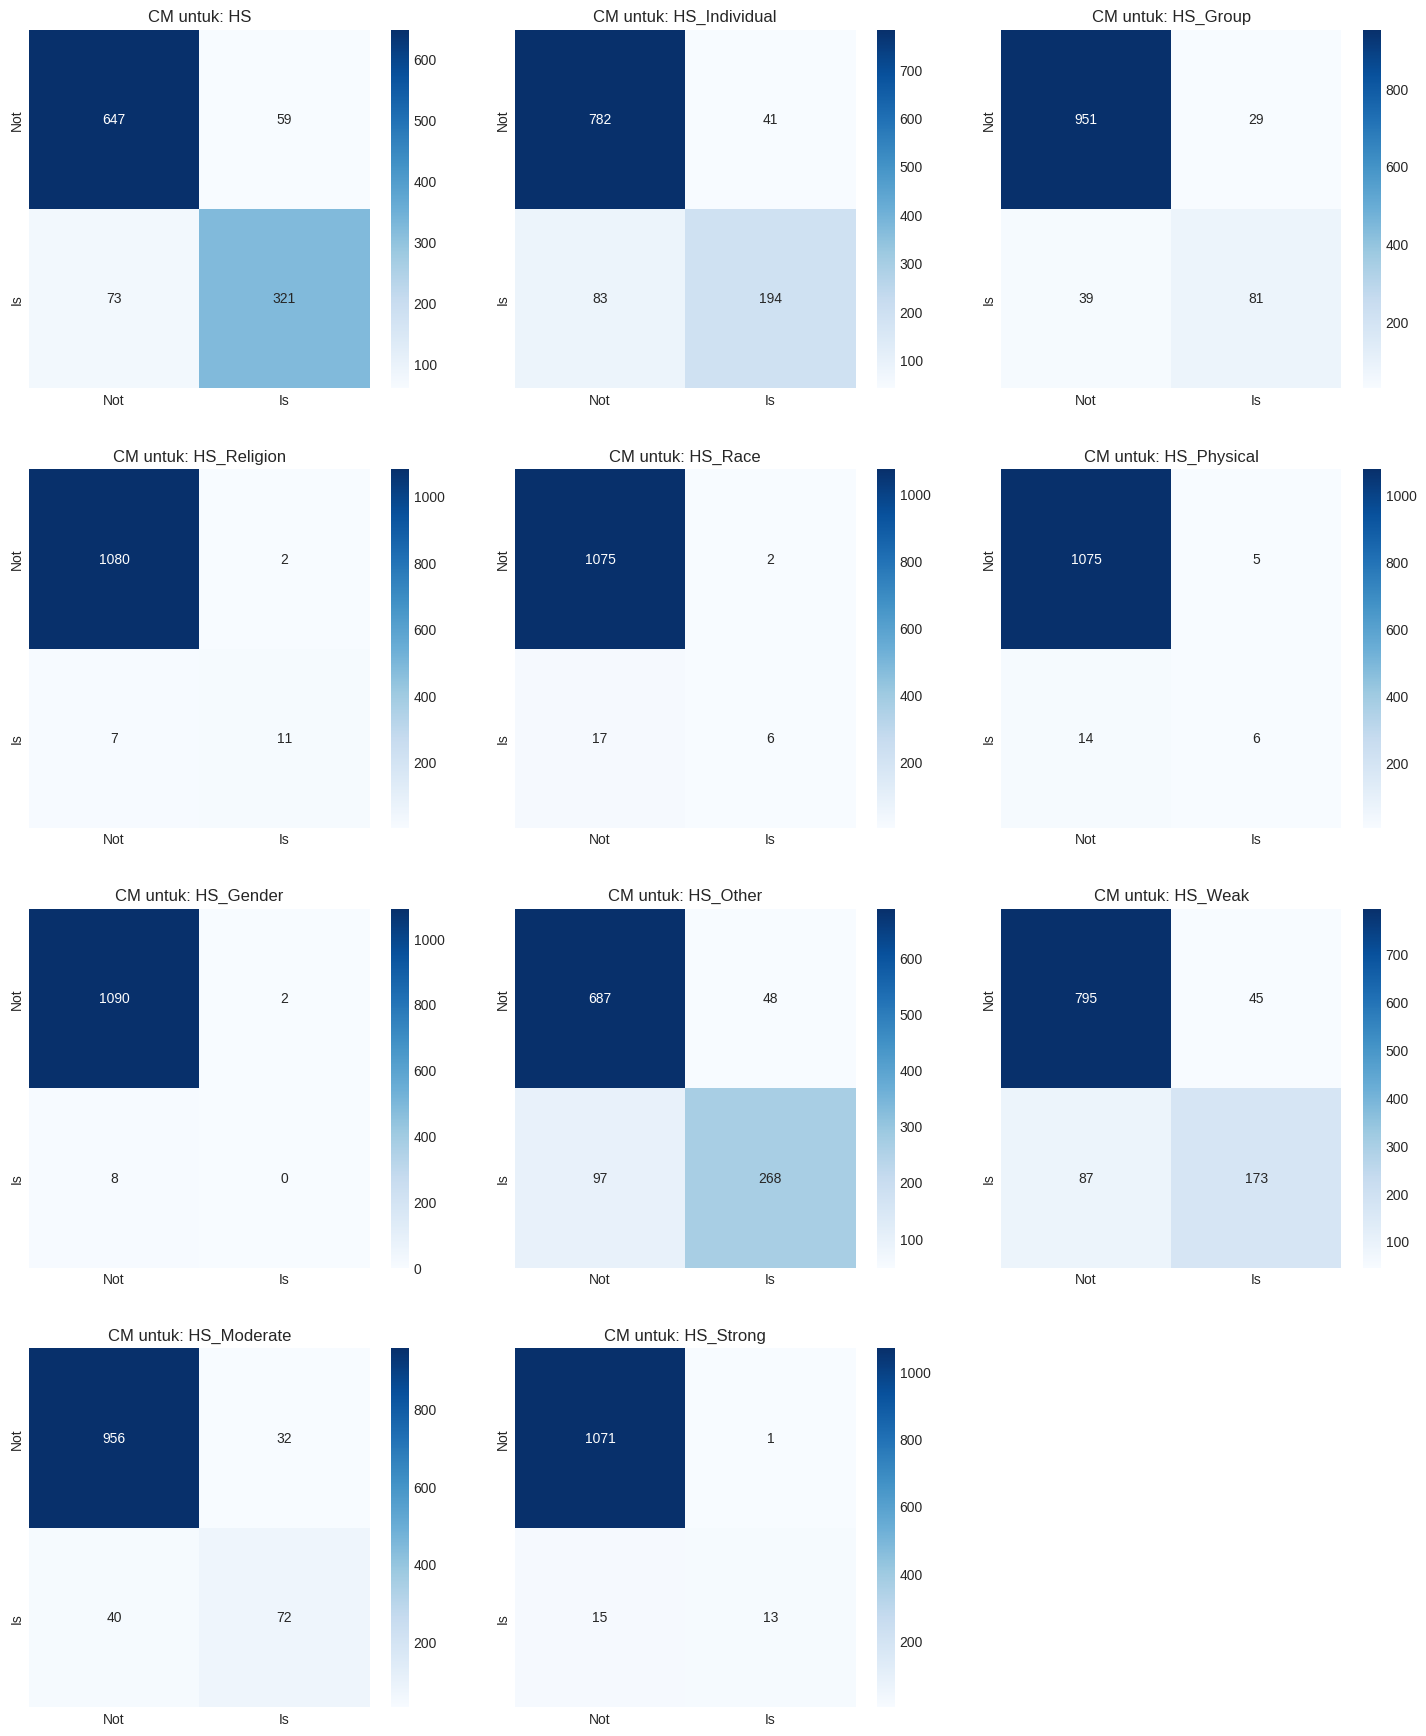

In [ ]:

PATH_MODEL_TERBAIK = "/content/drive/MyDrive/CODE SKRIPSI/revisi/MODEL_FINAL_SIDANG_REVISI"

OPTIMAL_THRESHOLDS = {
    'HS': 0.8, 'HS_Individual': 0.85, 'HS_Group': 0.77,
    'HS_Religion': 0.72, 'HS_Race': 0.36, 'HS_Physical': 0.39,
    'HS_Gender': 0.6, 'HS_Other': 0.84, 'HS_Weak': 0.88,
    'HS_Moderate': 0.71, 'HS_Strong': 0.82
}

print(f"Memuat model dari: {PATH_MODEL_TERBAIK}")

# Load model
model_final = AutoModelForSequenceClassification.from_pretrained(PATH_MODEL_TERBAIK)

# Membuat trainer sementara untuk prediksi
args_eval = TrainingArguments(output_dir="./temp_pengujian", report_to="none")
trainer_final = Trainer(model=model_final, args=args_eval)

print("\n" + "="*50)
print(f"Pengujian Final pada Dataset YouTube")
print("="*50)

predictions_output_yt = trainer_final.predict(youtube_dataset)
y_probas_yt = 1 / (1 + np.exp(-predictions_output_yt.predictions))
y_true_yt = predictions_output_yt.label_ids
y_pred_optimal_yt = np.zeros_like(y_probas_yt)

print("\nMenerapkan threshold optimal per label...")
for i, label in enumerate(label_columns):
    threshold = OPTIMAL_THRESHOLDS[label]
    y_pred_optimal_yt[:, i] = (y_probas_yt[:, i] > threshold).astype(int)

# Menampilkan laporan klasifikasi dan visualisasi
report_final_yt = classification_report(y_true_yt, y_pred_optimal_yt, target_names=label_columns, zero_division=0)
print("--- Laporan Klasifikasi Final pada Dataset YouTube ---")
print(report_final_yt)

display_evaluation_visuals(y_true_yt, y_pred_optimal_yt, label_columns, dataset_name="YouTube")